In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import chain
from sklearn.metrics import roc_auc_score
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
# Load IUCPQ data (clinical & radiomics)
clinical = pd.read_csv("../../Data/clinical_IUCPQ.csv")
radiomics = pd.read_csv("../../Data/PyRads_IUCPQ.csv")

## Load IUCPQ data (clinical & radiomics)
#clinical_test = pd.read_csv("../../Data/clinical_IUCPQ.csv")
#radiomics_test = pd.read_csv("../../Data/PyRads_IUCPQ.csv")

# Build Predictors

In [3]:
def add_tertile_binary(df_temp, dist_column, new_column):
    df = df_temp.copy()
    df[new_column] = pd.qcut(df[dist_column], 3, labels=False, retbins=False, precision=3, duplicates='raise')
    #print(df[column])
    df = df[df[new_column] != 1]
    df[new_column][df[new_column] == 0] = 1
    df[new_column][df[new_column] == 2] = 0
    return df

def prep_clinical_class(df):
    # always 1 if smaller is true
    df["pdl1_bi"] = 0
    df["pdl1_bi"][df.pdl1_group.isin(["<1%", "1-49%"])] = 1
    #df["pfs_6months"]
    #df["pfs_1year"]
    clinical_pfs_tertile = add_tertile_binary(df, "pfs_days", "pfs_tertile",)
    clinical_os_tertile = add_tertile_binary(df,"os_days", "os_tertile")
    return df, clinical_pfs_tertile, clinical_os_tertile

In [4]:
clinical, clinical_pfs_tertile, clinical_os_tertile = prep_clinical_class(clinical)
#clinical_test, clinical_pfs_tertile_test, clinical_os_tertile_test = prep_clinical_class(clinical_test)

In [5]:
clinical.first_line_io.value_counts()

No              146
Yes_alone        75
Yes_combined     10
Name: first_line_io, dtype: int64

# Grouping Analysis (4 Groups)

In [6]:
radio_features = radiomics.columns[2:]
middel_feats = []
for feature in radio_features:
    split = feature.split("_")
    if split[1] not in middel_feats:
        middel_feats.append(split[1])
middel_feats

['shape', 'firstorder', 'glcm', 'glszm', 'glrlm', 'ngtdm', 'gldm']

In [7]:
texture = ["glcm", "glszm", "glrlm", "ngtdm", "gldm"]
original_shape = []
original_firstorder = []
original_texture = []
wavelet = []

for feature in radio_features:
    if "original_shape" in feature:
        original_shape.append(feature)
    elif "original_firstorder" in feature:
        original_firstorder.append(feature)
    for text in texture:
        if "original_"+ text in feature:
            original_texture.append(feature)
    if "wavelet" in feature:
        wavelet.append(feature)
print("Original Shape Features: ", len(original_shape))
print("Original Firstorder Features: ", len(original_firstorder))
print("Original Texture Features: ", len(original_texture))
print("Wavelet Features: ", len(wavelet))

Original Shape Features:  14
Original Firstorder Features:  18
Original Texture Features:  75
Wavelet Features:  744


# Fit Logistic Regression to Predictors

In [8]:
radio_features = radiomics.columns[2:]
#predictors = ["pfs_6months", "pfs_1year", "pfs_tertile", "os_tertile","pdl1_tps", "pfs_days", "os_days"] # "pdl1_bi"
predictors = ["pdl1_tps", "pfs_days", "os_days"]
immo_groups = ["all", 'Pembrolizumab', 'Nivolumab', 'Atezolizumab', 'No', 'Yes_alone']
p_val_all = pd.DataFrame(index=radio_features)
p_val_all = p_val_all.reset_index().rename(columns={"index": "Feature"})
for predictor in predictors: # predictors
    print("######### Predictor: "+predictor+ "#####################")
    if predictor == "pfs_tertile":
        merge = radiomics.merge(clinical_pfs_tertile, on ="oncotech_id", how="inner")
        #merge_test = radiomics_test.merge(clinical_pfs_tertile_test, on ="oncotech_id", how="inner")
    elif predictor == "os_tertile":
        merge = radiomics.merge(clinical_os_tertile, on ="oncotech_id", how="inner")
        #merge_test = radiomics_test.merge(clinical_os_tertile_test, on ="oncotech_id", how="inner")
    else:
        merge = radiomics.merge(clinical, on ="oncotech_id", how="inner")
        #merge_test = radiomics_test.merge(clinical_test, on ="oncotech_id", how="inner") 
    
    for imm_group in immo_groups:
        col_name = imm_group + "_p_val_" +predictor
        if predictor in ["pdl1_tps", "pfs_days", "os_days"]:
            p_val_df = pd.DataFrame(columns=["Feature", col_name + "_pearson", col_name + "_spearman"]) # auc_col_name
        else:
            p_val_df = pd.DataFrame(columns=["Feature", col_name])

        if imm_group == 'Pembrolizumab':
            merge_group = merge[merge.io_type == 'Pembrolizumab']
        elif imm_group == 'Nivolumab':
            merge_group = merge[merge.io_type == 'Nivolumab']
        elif imm_group == 'Atezolizumab':
            merge_group = merge[merge.io_type == 'Atezolizumab']
        elif imm_group == 'No':
            merge_group = merge[merge.first_line_io == 'No']
        elif imm_group == 'Yes_alone':
            merge_group = merge[merge.first_line_io == 'Yes_alone']
        else:
            merge_group = merge
        
        for feat in radio_features:
            # building training set and fitting model to data
            merge_group = merge_group[merge_group[predictor].notna()]
            num_path_in_group = len(merge_group)
            Xtrain = merge_group[[feat]]
            ytrain = merge_group[[predictor]]

            if num_path_in_group != len(Xtrain):
                print(len(Xtrain))
                print(Xtrain)

            if predictor in ["pdl1_tps", "pfs_days", "os_days"]:
                #p_val_df = pd.DataFrame(columns=["Feature", col_name + "_pearson", col_name + "_spearman"]) # auc_col_name
                corr, p_temp_pearson = pearsonr(Xtrain.values.flatten(), ytrain.values.flatten())
                corr, p_temp_spearman = spearmanr(Xtrain.values.flatten(), ytrain.values.flatten())
                row_temp = pd.DataFrame(dict(zip(["Feature", col_name+ "_pearson", col_name + "_spearman"], [feat, p_temp_pearson, p_temp_spearman])), index=[0]) #auc_col_name  roc_score
                p_val_df = pd.concat([p_val_df,row_temp])
            else:
                log_reg = sm.Logit(ytrain, Xtrain).fit()
                p_temp = log_reg.pvalues[0]
                row_temp = pd.DataFrame(dict(zip(["Feature", col_name], [feat, p_temp])), index=[0]) #auc_col_name  roc_score
                p_val_df = pd.concat([p_val_df,row_temp])

            
            # test on test set
            #Xtest = merge_test[[feat]]
            #ytest = merge_test[[predictor]]
            #y_preds = log_reg.predict(Xtest)
            #prediction = list(map(round, y_preds))
            #roc_score = roc_auc_score(list(ytest.values), prediction)
            
            #p_val_df = pd.concat([p_val_df,row_temp])
        p_val_all = p_val_all.merge(p_val_df, on= "Feature")
    #p_val_all = p_val_all.merge(p_val_df, on= "Feature")
    

######### Predictor: pdl1_tps#####################
######### Predictor: pfs_days#####################
######### Predictor: os_days#####################


In [9]:
p_val_all

,Feature,all_p_val_pdl1_tps_pearson,all_p_val_pdl1_tps_spearman,Pembrolizumab_p_val_pdl1_tps_pearson,Pembrolizumab_p_val_pdl1_tps_spearman,Nivolumab_p_val_pdl1_tps_pearson,Nivolumab_p_val_pdl1_tps_spearman,Atezolizumab_p_val_pdl1_tps_pearson,Atezolizumab_p_val_pdl1_tps_spearman,No_p_val_pdl1_tps_pearson,...,Pembrolizumab_p_val_os_days_pearson,Pembrolizumab_p_val_os_days_spearman,Nivolumab_p_val_os_days_pearson,Nivolumab_p_val_os_days_spearman,Atezolizumab_p_val_os_days_pearson,Atezolizumab_p_val_os_days_spearman,No_p_val_os_days_pearson,No_p_val_os_days_spearman,Yes_alone_p_val_os_days_pearson,Yes_alone_p_val_os_days_spearman
0,original_shape_Elongation,0.747297,0.800881,0.427436,0.361667,0.925382,0.779090,0.005539,0.167223,0.538962,...,0.041395,0.190677,0.290121,0.183495,0.208907,0.288583,0.146123,0.057830,0.029235,0.049149
1,original_shape_Flatness,0.678133,0.503747,0.178898,0.123550,0.016752,0.002748,0.041068,0.008886,0.332299,...,0.062843,0.275459,0.016257,0.011916,0.757271,0.957376,0.044488,0.024100,0.021673,0.076958
2,original_shape_LeastAxisLength,0.426172,0.638184,0.607649,0.988166,0.023410,0.028861,0.049444,0.019285,0.301446,...,0.126237,0.139144,0.028186,0.015499,0.120415,0.122332,0.049000,0.021944,0.011831,0.050792
3,original_shape_MajorAxisLength,0.348728,0.809707,0.675356,0.468116,0.042156,0.165284,0.120739,0.054136,0.328682,...,0.161169,0.311337,0.071792,0.090737,0.074764,0.051771,0.095512,0.118334,0.018404,0.121114
4,original_shape_Maximum2DDiameterColumn,0.361986,0.824649,0.632596,0.524414,0.049153,0.196287,0.148910,0.042922,0.361246,...,0.086798,0.164345,0.048123,0.081135,0.084277,0.054647,0.067128,0.087605,0.007192,0.062174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,wavelet.LLL_gldm_LargeDependenceLowGrayLevelEm...,0.329438,0.004831,0.686755,0.107626,0.432315,0.631092,0.000145,0.416587,0.389814,...,0.162456,0.377747,0.044869,0.015137,0.274335,0.858504,0.788652,0.056019,0.468198,0.197147
847,wavelet.LLL_gldm_LowGrayLevelEmphasis,0.860418,0.207431,0.438329,0.525794,0.541352,0.390543,0.000129,0.019285,0.720242,...,0.027059,0.447154,0.407768,0.735991,0.209483,0.344000,0.551849,0.528628,0.098225,0.257974
848,wavelet.LLL_gldm_SmallDependenceEmphasis,0.294244,0.334999,0.291564,0.455095,0.199829,0.330771,0.012141,0.025668,0.628385,...,0.061396,0.115367,0.067166,0.049359,0.121625,0.262943,0.098514,0.075361,0.007601,0.007117
849,wavelet.LLL_gldm_SmallDependenceHighGrayLevelE...,0.048743,0.067574,0.952403,0.727216,0.395400,0.920929,0.053939,0.067295,0.055600,...,0.506862,0.357267,0.551363,0.525346,0.974202,0.517131,0.936414,0.766071,0.675457,0.624528


# Evaluation of p-values

## 4 Groups

In [10]:
def add_group_col(df):
    df["Group"] = np.nan
    df["Group"][df["Feature"].isin(original_shape)] = "shape"
    df["Group"][df["Feature"].isin(original_firstorder)] = "firstorder"
    df["Group"][df["Feature"].isin(original_texture)] = "texture"
    df["Group"][df["Feature"].isin(wavelet)] = "wavelet"
    df.Group.isna().any()
    return df
p_val_all = add_group_col(p_val_all)

In [11]:
corr_meth = ["pearson", "spearman"]
def add_correct_p_val(df):
    for predictor in predictors:
        for imm_group in immo_groups:
                if predictor in ["pdl1_tps", "pfs_days", "os_days"]:
                    for corr in corr_meth:
                        p_val_arr = np.array(df[imm_group+"_p_val_"+predictor+"_"+corr])
                        reject, p_val_corrected = fdrcorrection(pvals=p_val_arr)
                        df[imm_group+"_FDR_corr_"+predictor+"_"+corr] = p_val_corrected
                else:
                    p_val_arr = np.array(df[imm_group+"_p_val_"+predictor])
                    reject, p_val_corrected = fdrcorrection(pvals=p_val_arr)
                    df[imm_group+"_FDR_corr_"+predictor] = p_val_corrected
            #df["-log10(FDR)_"+predictor] = -np.log10(p_val_corrected)
    return df
p_val_all_corr = add_correct_p_val(p_val_all)

In [12]:
p_val_all_corr

,Feature,all_p_val_pdl1_tps_pearson,all_p_val_pdl1_tps_spearman,Pembrolizumab_p_val_pdl1_tps_pearson,Pembrolizumab_p_val_pdl1_tps_spearman,Nivolumab_p_val_pdl1_tps_pearson,Nivolumab_p_val_pdl1_tps_spearman,Atezolizumab_p_val_pdl1_tps_pearson,Atezolizumab_p_val_pdl1_tps_spearman,No_p_val_pdl1_tps_pearson,...,Pembrolizumab_FDR_corr_os_days_pearson,Pembrolizumab_FDR_corr_os_days_spearman,Nivolumab_FDR_corr_os_days_pearson,Nivolumab_FDR_corr_os_days_spearman,Atezolizumab_FDR_corr_os_days_pearson,Atezolizumab_FDR_corr_os_days_spearman,No_FDR_corr_os_days_pearson,No_FDR_corr_os_days_spearman,Yes_alone_FDR_corr_os_days_pearson,Yes_alone_FDR_corr_os_days_spearman
0,original_shape_Elongation,0.747297,0.800881,0.427436,0.361667,0.925382,0.779090,0.005539,0.167223,0.538962,...,0.202320,0.420379,0.476431,0.288584,0.327703,0.466004,0.292938,0.123341,0.139406,0.156650
1,original_shape_Flatness,0.678133,0.503747,0.178898,0.123550,0.016752,0.002748,0.041068,0.008886,0.332299,...,0.245320,0.483863,0.059892,0.038557,0.811635,0.976891,0.185586,0.072065,0.118228,0.190935
2,original_shape_LeastAxisLength,0.426172,0.638184,0.607649,0.988166,0.023410,0.028861,0.049444,0.019285,0.301446,...,0.303467,0.371094,0.090175,0.048137,0.317987,0.361415,0.190522,0.067173,0.091758,0.160353
3,original_shape_MajorAxisLength,0.348728,0.809707,0.675356,0.468116,0.042156,0.165284,0.120739,0.054136,0.328682,...,0.352584,0.508119,0.177602,0.166364,0.317987,0.361415,0.244870,0.203028,0.105358,0.244324
4,original_shape_Maximum2DDiameterColumn,0.361986,0.824649,0.632596,0.524414,0.049153,0.196287,0.148910,0.042922,0.361246,...,0.278295,0.384214,0.132962,0.153777,0.317987,0.361415,0.206217,0.162358,0.087120,0.172345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,wavelet.LLL_gldm_LargeDependenceLowGrayLevelEm...,0.329438,0.004831,0.686755,0.107626,0.432315,0.631092,0.000145,0.416587,0.389814,...,0.352592,0.538174,0.126435,0.047409,0.387162,0.908690,0.838602,0.121612,0.708961,0.341695
847,wavelet.LLL_gldm_LowGrayLevelEmphasis,0.860418,0.207431,0.438329,0.525794,0.541352,0.390543,0.000129,0.019285,0.720242,...,0.195393,0.567106,0.598453,0.829574,0.327703,0.518131,0.656816,0.621342,0.263968,0.416576
848,wavelet.LLL_gldm_SmallDependenceEmphasis,0.294244,0.334999,0.291564,0.455095,0.199829,0.330771,0.012141,0.025668,0.628385,...,0.244151,0.350633,0.169609,0.107982,0.317987,0.440482,0.247988,0.147092,0.087120,0.107892
849,wavelet.LLL_gldm_SmallDependenceHighGrayLevelE...,0.048743,0.067574,0.952403,0.727216,0.395400,0.920929,0.053939,0.067295,0.055600,...,0.664622,0.535961,0.718545,0.652656,0.985223,0.676004,0.946423,0.812288,0.845314,0.789058


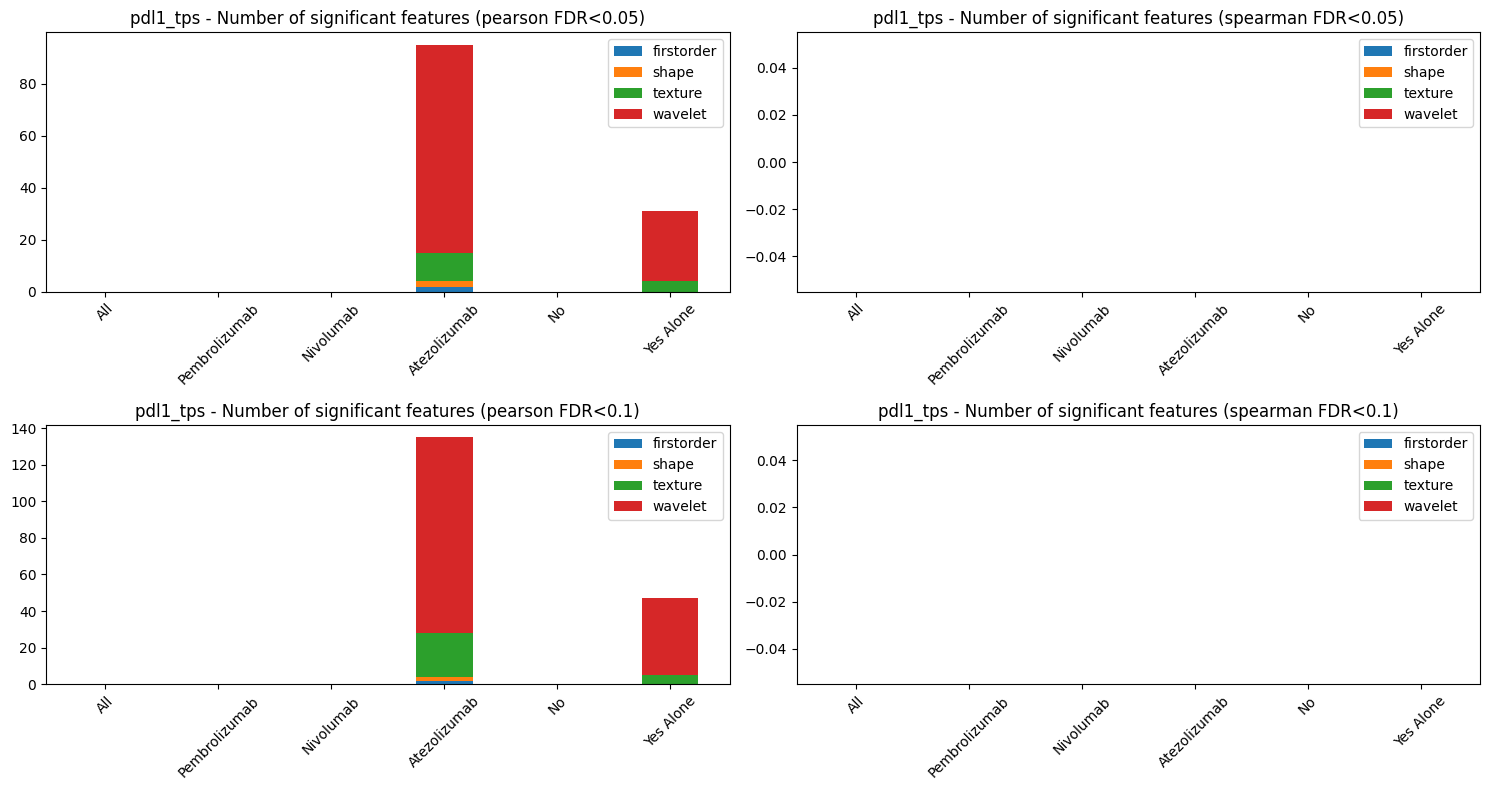

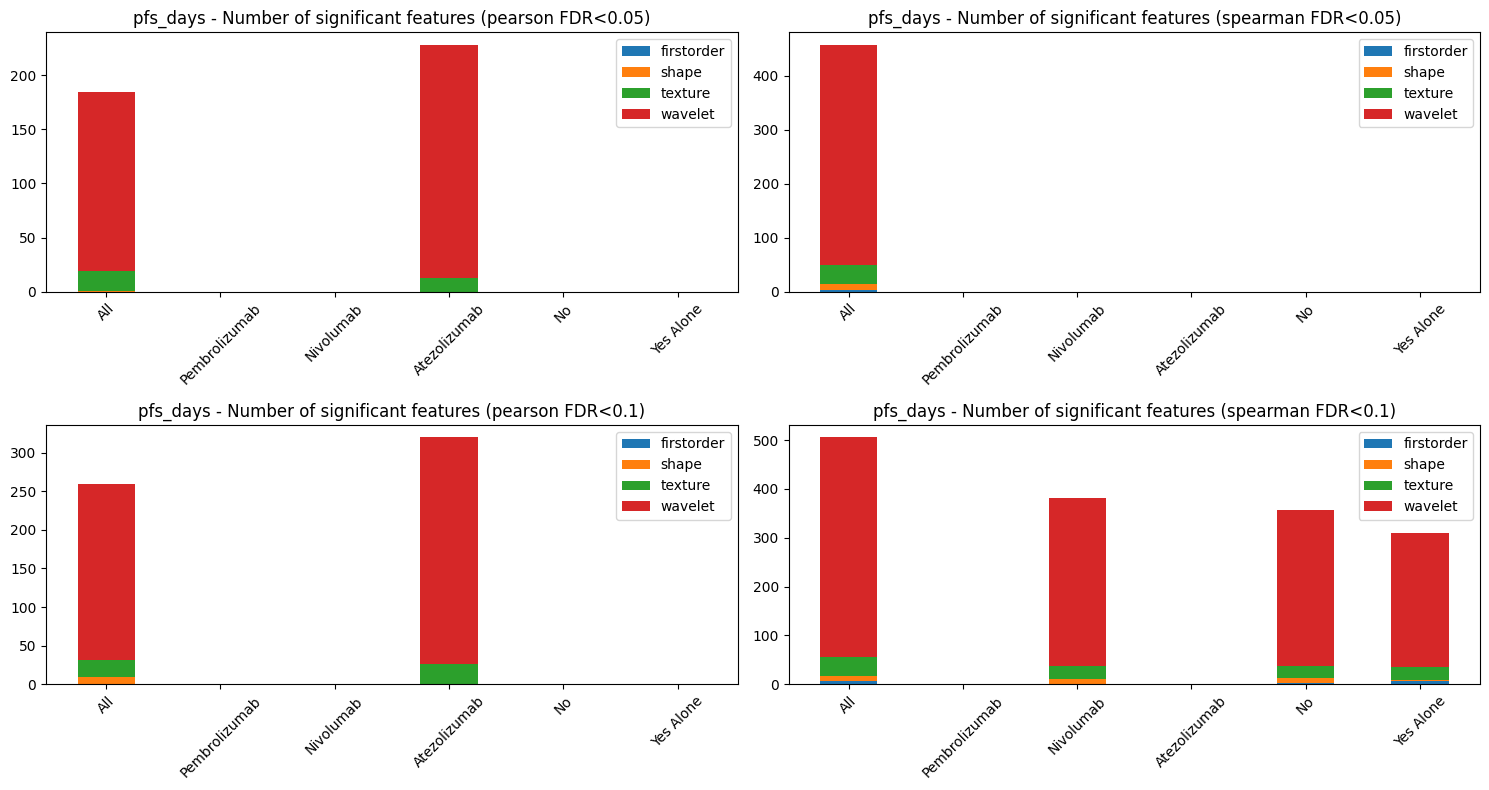

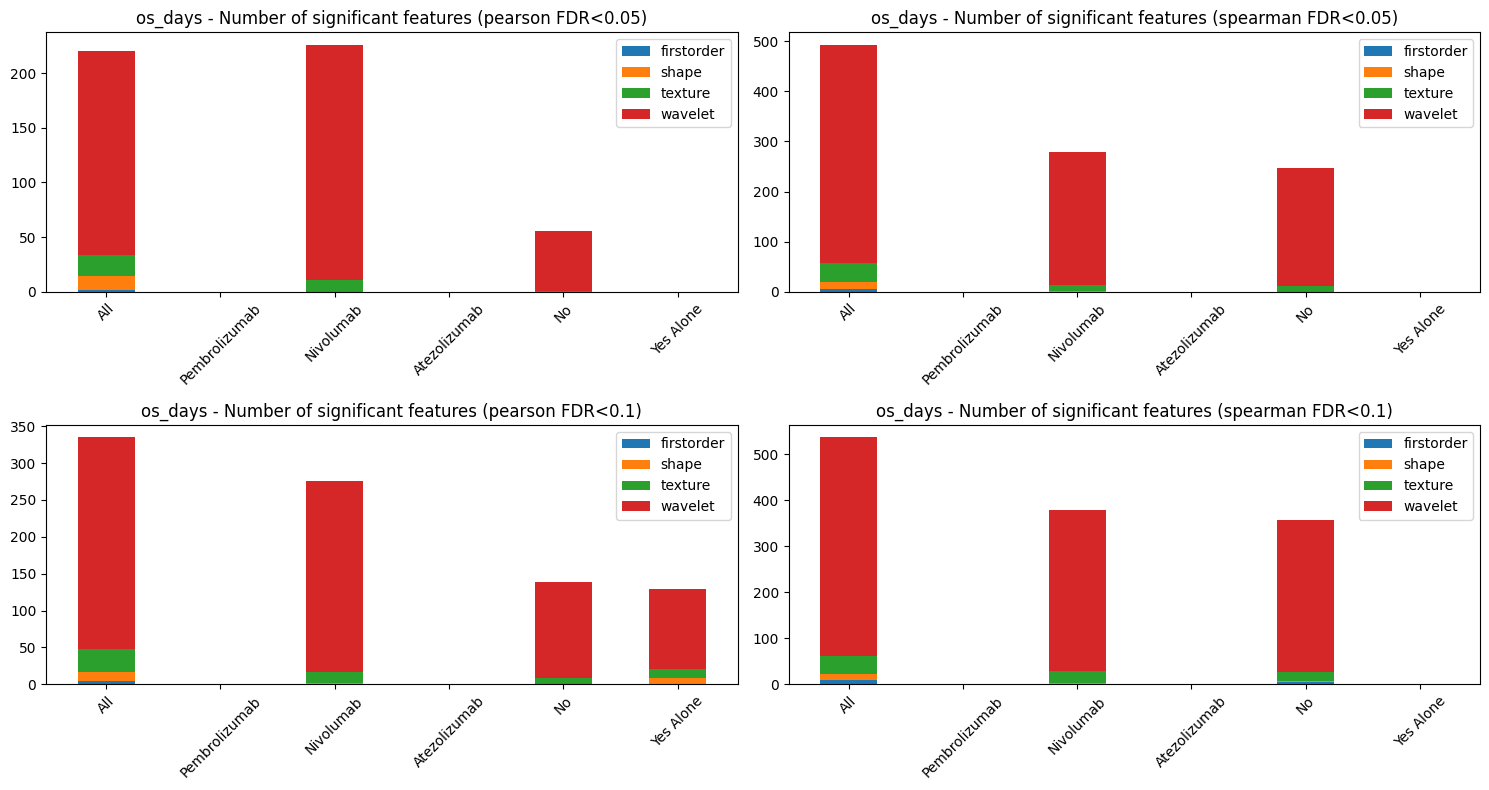

In [30]:
def get_stacked_bar_plot_corr(predictor):
    fig, ax = plt.subplots(2,2, figsize=(15, 8))
    for num_p, p_value in enumerate([0.05, 0.1]):
        # Is p value significant? <p_value
        for num_corr, corr in enumerate(corr_meth):
            for imm_group in immo_groups:
                p_val_all_corr[imm_group+"_FDR_corr_"+predictor+"_"+corr+"_sig"] = np.where(p_val_all_corr[imm_group+"_FDR_corr_"+predictor+"_"+corr]<p_value, 1, 0)
                #print(imm_group+"_FDR_corr_"+predictor+"_sig")
            # Count how many significant per group
            num_signific_group = p_val_all_corr[["Group", "all_FDR_corr_"+predictor+"_"+corr+"_sig","Pembrolizumab_FDR_corr_"+predictor+"_"+corr+"_sig", "Nivolumab_FDR_corr_"+predictor+"_"+corr+"_sig" , "Atezolizumab_FDR_corr_"+predictor+"_"+corr+"_sig",  "No_FDR_corr_"+predictor+"_"+corr+"_sig", "Yes_alone_FDR_corr_"+predictor+"_"+corr+"_sig"]].groupby(by="Group").sum()
            num_signific_group.reset_index(inplace=True)
            #display(num_signific_group)

            # Preperation of data for Bar Plot
            group = ("All", "Pembrolizumab", "Nivolumab", "Atezolizumab", "No", "Yes Alone") # "Imm1", Imm2, "Imm3"
            feature_group = list(num_signific_group.Group)
            #values = num_signific_group["-log10(FDR)_pdl1_bi_sig"].values
            values_list = []
            for i in range(len(num_signific_group)):
                values_list.append(np.array(num_signific_group.iloc[i].values[1:].astype(float)))
            feature_group_dict = dict(zip(feature_group, values_list))
            # PLOT
            width = 0.5
            bottom = np.zeros(6)
            for feature_type, num_sig_feats in feature_group_dict.items():
                p = ax[num_p, num_corr].bar(group, num_sig_feats, width, label=feature_type, bottom=bottom)
                #p = ax.bar(group, num_sig_feats, width, label=feature_type, bottom=bottom)
                bottom += num_sig_feats

                ax[num_p, num_corr].set_title(predictor + " - Number of significant features ({} FDR<{})".format(corr, p_value))
                ax[num_p, num_corr].legend(loc="upper right")
                ax[num_p, num_corr].set_xticks(range(len(group)))
                ax[num_p, num_corr].set_xticklabels(group, rotation=45)
                #plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

predictors_testing = ["pdl1_tps", "pfs_days", "os_days"]
for predictor in predictors_testing:
    get_stacked_bar_plot_corr(predictor)

In [15]:
def get_stacked_bar_plot_class(p_value, predictor):
    # Is p value significant? <p_value
    for imm_group in immo_groups:
        p_val_all_corr[imm_group+"_FDR_corr_"+predictor+"_sig"] = np.where(p_val_all_corr[imm_group+"_FDR_corr_"+predictor]<p_value, 1, 0)
        #print(imm_group+"_FDR_corr_"+predictor+"_sig")
    # Count how many significant per group
    num_signific_group = p_val_all_corr[["Group", "all_FDR_corr_"+predictor+"_sig","Pembrolizumab_FDR_corr_"+predictor+"_sig", "Nivolumab_FDR_corr_"+predictor+"_sig" , "Atezolizumab_FDR_corr_"+predictor+"_sig"]].groupby(by="Group").sum()
    num_signific_group.reset_index(inplace=True)

    # Preperation of data for Bar Plot
    group = ("All", "Pembrolizumab", "Nivolumab", "Atezolizumab") # "Imm1", Imm2, "Imm3"
    feature_group = list(num_signific_group.Group)
    #values = num_signific_group["-log10(FDR)_pdl1_bi_sig"].values
    values_list = []
    for i in range(len(num_signific_group)):
        values_list.append(np.array(num_signific_group.iloc[i].values[1:].astype(float)))
    values_list
    feature_group_dict = dict(zip(feature_group, values_list))
    width = 0.5

    fig, ax = plt.subplots(2)
    bottom = np.zeros(4)

    for boolean, weight_count in feature_group_dict.items():
        p = ax[0].bar(group, weight_count, width, label=boolean, bottom=bottom)
        p = ax[1].bar(group, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count

    ax.set_title(predictor + " - Number of significant features (FDR<{})".format(p_value))
    ax.legend(loc="upper right")

    plt.show()

In [31]:
predictor = predictors[-2] # == pdl1_tsp
p_value = 0.1
get_stacked_bar_plot_class(p_value, predictor)

KeyError: 'all_FDR_corr_pfs_days'

## 55 Groups

In [ ]:
def get_list_begin_feats():
    # list of the groups like original_shape, wavelet.LL....
    unique_starts = []
    for feat in radio_features:
        feat_split = feat.split("_")
        str_temp = feat_split[0] + "_" + feat_split[1]
        
        #print(str_temp)
        if str_temp not in unique_starts:
            unique_starts.append(str_temp)
    return unique_starts

def get_grouped_feats():
    # Array of the features assigned to one of the groups
    unique_starts = get_list_begin_feats()
    grouped_feats = np.empty(len(unique_starts), dtype=object)
    grouped_feats[:] = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    for i, group_feat in enumerate(unique_starts):
        for feat in radio_features:
            if group_feat in feat:
                if (group_feat == "original_firstorder") and (feat == "original_firstorder_10Percentile"):
                    print("hello")
                grouped_feats[i].append(feat)
    #print(grouped_feats)
    return grouped_feats

grouped_feats = get_grouped_feats()

In [ ]:
# Feature lists for original and wavelet group
original_all = []
wavelet_all = []

for feats in radio_features:
    if "original" in feats:
        original_all.append(feats)
    elif "wavelet" in feats:
        wavelet_all.append(feats)   

In [ ]:
# Assign a group to the feature in dataframe
p_val_all["Group"] = np.nan
group_temp = 0
for idx, feature in enumerate(p_val_all.Feature):
    if feature not in grouped_feats[group_temp]:
        group_temp += 1
    else:
        p_val_all["Group"].iloc[idx] = group_temp

In [ ]:
grouped_feats

In [ ]:
p_val_all[p_val_all.Group.isna()]

# Plotting
## 55 groups
### Matplotlib

In [ ]:
def get_list_group_labels_x():
    label_list = []
    unique_starts = get_list_begin_feats()

    for i in range(len(grouped_feats)):
        label_temp = unique_starts[i]
        
        list_temp = list(len(grouped_feats[i]) * [label_temp])
        label_list.append(list_temp)
    label_list = list(chain.from_iterable(label_list))
    return label_list

In [ ]:
df_temp = p_val_all[p_val_all.Group == 0]
df_temp

In [ ]:
def plot_55_feats(predictor):
    fig, ax = plt.subplots(figsize=(15,5))
    for group in p_val_all['Group'].unique():
        df_temp = p_val_all[p_val_all.Group == group]
        ax.plot(df_temp.Feature, df_temp[predictor], marker='o', linestyle='', ms=3,  label=df_temp['Group'].iloc[0])
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.set_title(label=predictor)
    ax.set_xticks(ticks= p_val_all.Feature) #, labels=get_list_group_labels_x
    ax.set_xticklabels(get_list_group_labels_x(), rotation='vertical', fontsize=4)
    ax.tick_params(axis='x', which='major', labelsize=5, rotation=90)
    

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
    #plt.xticks(rotation=90)#
    plt.axhline(y=0.05, color='r', linestyle='-')
    plt.show()

In [ ]:
for predictor in predictors:
    plot_55_feats("p_val_"+predictor)

### Seaborn tests

In [ ]:
import seaborn as sns

sns.scatterplot(x=p_val_all.Feature, y=p_val_all["p_val_pfs_6months"], data=p_val_all, hue="Group")

### Test Pandas scatter + Rainbow

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, len(grouped_feats)))
np.random.shuffle(colors)
ax = p_val_all.plot.scatter(x="Feature", y="p_val_pfs_6months", alpha=.7, c=p_val_all['Group'].map(dict(zip(p_val_all.Group.unique(), colors))), figsize=(15,5))
ax.legend(fontsize='small')

# Original and Wavelet group

In [ ]:
p_val_all["wavelet"] = 0
p_val_all["wavelet"][p_val_all.Feature.isin(wavelet_all)] = 1

In [ ]:
def plot_2_feats(predictor):
    fig, ax = plt.subplots(figsize=(15,5))
    for group in p_val_all['wavelet'].unique():
        df_temp = p_val_all[p_val_all.wavelet == group]
        ax.plot(df_temp.Feature, df_temp[predictor], marker='o', linestyle='', ms=3,  label=df_temp['wavelet'].iloc[0])
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.set_title(label=predictor)
    ax.set_xticks(ticks= p_val_all.Feature) #, labels=get_list_group_labels_x
    ax.set_xticklabels(get_list_group_labels_x(), rotation='vertical', fontsize=4)
    ax.tick_params(axis='x', which='major', labelsize=5, rotation=90)

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
    #plt.xticks(rotation=90)
    plt.show()
plot_2_feats("p_val_"+ predictors[0])

In [ ]:
p_val_all

# Problems with how classes were assigned (check)

In [ ]:
def add_os_day_class(df):
    df["class_os_days"] = pd.qcut(df.os_days, 3, labels=False, retbins=False, precision=3, duplicates='raise')
    df = df[df.class_os_days != 1]
    df["class_os_days"][df.class_os_days != 2] = 1
    df["class_os_days"][df.class_os_days == "nan"] = np.nan
    df = df[df.class_os_days.notna()]
    df = df.drop(columns=["os_days"])
    df = df.reset_index(drop=True)
    df["class_os_days"] = df["class_os_days"].astype('int')
    print(df)
    return df
add_os_day_class(clinical)